In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import math

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#path axel
DATA_HOME = r"/content/gdrive/My Drive/UBA/machine_learning/tps"
# path Noe 
#DATA_HOME = r"/content/gdrive/My Drive/tp1"
df = pd.read_csv(
    DATA_HOME + "/healthcare-dataset-stroke-data.csv"
)


In [5]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
df.corr()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
id,1.000000,0.003538,0.003550,-0.001296,0.001092,0.003084,0.006388
age,0.003538,1.000000,0.276398,0.263796,0.238171,0.333398,0.245257
hypertension,0.003550,0.276398,1.000000,0.108306,0.174474,0.167811,0.127904
heart_disease,-0.001296,0.263796,0.108306,1.000000,0.161857,0.041357,0.134914
avg_glucose_level,0.001092,0.238171,0.174474,0.161857,1.000000,0.175502,0.131945
bmi,0.003084,0.333398,0.167811,0.041357,0.175502,1.000000,0.042374
stroke,0.006388,0.245257,0.127904,0.134914,0.131945,0.042374,1.000000


In [7]:
df.id.value_counts().max()

1

## Preprocesamiento y definición de módulos básicos 
- Preprocesamiento de datos
- Clase Evaluatoror (mismo que el de Pablo), usamos como métrica por el momento ROC-AUC

In [8]:
# Definir métrica 

from sklearn.metrics import roc_auc_score # si uso roc_auc, uso predict_proba 
                                          # con proba de ACV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import log_loss

class Evaluator:
    def __init__(self, X_train, y_train, X_dev, y_dev, X_test=None, y_test=None):
        self.X_train = X_train
        self.y_train = y_train
        self.X_dev = X_dev
        self.y_dev = y_dev
        self.X_test = X_test
        self.y_test = y_test
        self.evaluations = []

    def eval_pipe(self, model_name, pipe): 
        res = self.eval_prediction(model_name, pipe.predict_proba(self.X_train)[:,1], pipe.predict_proba(self.X_dev)[:,1])
        if self.X_test is not None:
            # res['test'] = 1-mean_absolute_error(self.y_test, pipe.predict_proba(self.X_test)[:,1])
            res['test'] = log_loss(self.y_test, pipe.predict_proba(self.X_test)[:,1])
            # res['test'] = 1 - sum(abs(self.y_test - pipe.predict_proba(self.X_test)[:,1]))/len(self.y_test)
        return res

    def eval_prediction(self, model_name, y_hat_train, y_hat_dev):
        res = dict(
            name=model_name,
            train= 1- log_loss(self.y_train, y_hat_train),
            dev  = 1- log_loss(self.y_dev, y_hat_dev, ),
            #train= 1- mean_absolute_error(self.y_train, y_hat_train),
            #dev  = 1- mean_absolute_error(self.y_dev, y_hat_dev, )
          
        )

        self.evaluations.append(res)
        return res

### Data preprocessing basico
Limpieza de observaciones malas y particion x e y

In [9]:
df = df[df.gender != "Other"]
df = df.drop(["work_type",	"Residence_type", "id"], axis=1)

In [10]:
ydf = df["stroke"]
xdf = df.loc[:, df.columns != "stroke"]

Division de dataset para validacion cruzada

In [11]:
xtrain, xdev, ytrain, ydev = train_test_split(xdf, ydf, stratify=ydf, test_size=1/5, random_state=420)

In [12]:
xdev, xtest, ydev, ytest = train_test_split(xdev, ydev, stratify=ydev, test_size=1/2, random_state=420)

In [13]:
sum(ytrain)/len(ytrain)

0.04869097137264497

In [14]:
sum(ydev)/len(ydev)

0.04892367906066536

In [15]:
sum(ytest)/len(ytest)

0.04892367906066536

# Noé 

## Pipelines generales 

In [16]:
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


In [17]:
from sklearn.compose import ColumnTransformer, make_column_transformer

bmi = ['bmi']
numericas = ['age', 'hypertension','avg_glucose_level']
categoricas = ["gender", "ever_married","smoking_status","heart_disease"]

# pipelines para bmi y otras numericas
imputer_pipe = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean'), 
    #StandardScaler()
)
scaler_pipe = make_pipeline(
     StandardScaler()
)
# pipelines para var cat
one_hot_pipe = make_pipeline(
    OneHotEncoder()
)
# preprocessor  sin modelado de missing values
preprocessor = make_column_transformer(
    (imputer_pipe, bmi),
    (scaler_pipe, numericas), 
    (one_hot_pipe, categoricas))

# preprocessor con modelado de missing value 

# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

preprocessor2 = make_pipeline(
    make_column_transformer(
        (scaler_pipe, numericas), 
        (one_hot_pipe, categoricas)
    ), 
    IterativeImputer(random_state=42)
)

### Modelito para imputar missing Values
Imputamos BMI haciendo un regression para predecir los missing values

In [18]:
# BMI Imputer con linear regression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

class BMI_imputer(BaseEstimator, TransformerMixin):

  def __init__(self, bmi_column):
    self.bmi_column = bmi_column

  def fit(self, X, y=None):
    return self
  
  def transform(self, X, y=None):
    X_reg = X[~X[self.bmi_column].isna()].copy()
    reg_model = LinearRegression()
    reg_model.fit(
        pd.get_dummies(X_reg.loc[:, X_reg.columns != self.bmi_column]),
        X_reg.loc[:, X_reg.columns == self.bmi_column]
    )
    preds = reg_model.predict(pd.get_dummies(X.loc[:, X.columns != self.bmi_column]))
    X[self.bmi_column] = np.where(X[self.bmi_column].isna(), preds, X[self.bmi_column])
    return X 

pipe_bmi_lr = make_pipeline(
     BMI_imputer("bmi"), 
     make_column_transformer(
        (scaler_pipe, numericas), 
        (one_hot_pipe, categoricas)
      )
    ) 

In [19]:
# Probando 2: 
xtrain_bmi = xtrain.copy()
df_bmi    = xtrain[~xtrain["bmi"].isna()].copy() # df para el modelo
y_df_bmi  = df_bmi.bmi                                
x_df_bmi  = pd.get_dummies(df_bmi.loc[:, df_bmi.columns != "bmi"])
reg_model = LinearRegression()
reg_model.fit(x_df_bmi, y_df_bmi)
preds     = reg_model.predict(pd.get_dummies(xtrain_bmi.loc[:, xtrain_bmi.columns!= "bmi"]))
xtrain_bmi.bmi = np.where(xtrain_bmi.bmi.isna(), preds, xtrain_bmi.bmi)


In [20]:
# visualizar diagrama 
from sklearn import set_config
set_config(display='diagram')
display(preprocessor) 

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['bmi']),
                                ('pipeline-2',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['age', 'hypertension', 'avg_glucose_level']),
                                ('pipeline-3',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['gender', 'ever_married', 'smoking_status',
                                  'heart_disease'])])

# Modelos

## Logistic Regression 
- version 1: con simpleImputer
- version 2: con IterativeImputer

In [21]:
from sklearn.linear_model import LogisticRegression

lr_pipe = make_pipeline(
    preprocessor, 
    LogisticRegression(
        class_weight= 'balanced', 
        multi_class = 'ovr')
)

lr2_pipe = make_pipeline(
    preprocessor2, 
    LogisticRegression(
        class_weight= 'balanced', 
        multi_class = 'ovr')
)

lr3_pipe = make_pipeline(
    pipe_bmi_lr, 
    LogisticRegression(
        class_weight= 'balanced', 
        multi_class = 'ovr')
)

In [22]:
lr1 = lr_pipe.fit(xtrain, ytrain)
lr2 = lr2_pipe.fit(xtrain, ytrain)
lr3 = lr3_pipe.fit(xtrain, ytrain)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


## LGBM


In [23]:
import lightgbm as lgb

lgb_pipe = make_pipeline(
    preprocessor, 
    lgb.LGBMClassifier(class_weight='balanced') 
)
lgb2_pipe = make_pipeline(
    preprocessor2, 
    lgb.LGBMClassifier(class_weight='balanced')
)

In [24]:
lgb = lgb_pipe.fit(xtrain, ytrain)
lgb2 = lgb2_pipe.fit(xtrain, ytrain)

Evaluamos los 4 modelos anteriores
- version default: con simpleImputer
- version 2: modelando missing values

In [25]:
ev = Evaluator(xtrain, ytrain, xdev, ydev)

# Hay que asegurarse que el pipeline de arriba tenga el titulo y no la descripccion
ev.eval_pipe('solo lr', lr_pipe)
ev.eval_pipe('lr con modelado de bmi', lr2_pipe)
ev.eval_pipe('lr con regresion de bmi ', lr3_pipe)
ev.eval_pipe('solo lgb', lgb_pipe)
ev.eval_pipe('lgb con modelado de bmi', lgb2_pipe) 

pd.DataFrame(ev.evaluations)

,name,train,dev
0,solo lr,0.500294,0.532009
1,lr con modelado de bmi,0.500310,0.531045
2,lr con regresion de bmi,0.500310,0.531045
3,solo lgb,0.843885,0.716945
4,lgb con modelado de bmi,0.843885,0.716945


In [26]:
lr1.predict_proba(xtrain)[:,1].shape

(4087,)

In [27]:
ytrain.shape

(4087,)

In [28]:
df_trainLR= pd.DataFrame(
    {
      'predicho' : lr1.predict_proba(xtrain)[:,1],
     'ytrain' : ytrain
    }
)

In [29]:
df_DEvLR= pd.DataFrame(
    {
      'predicho' : lr1.predict_proba(xdev)[:,1],
     'ydev' : ydev
    }
)

In [30]:
df_trainLGB= pd.DataFrame(
    {
      'predicho' : lgb.predict_proba(xtrain)[:,1],
     'ytrain' : ytrain
    }
)

In [31]:
df_devLGB= pd.DataFrame(
    {
      'predicho' : lgb.predict_proba(xdev)[:,1],
     'ydev' : ydev
    }
)

In [32]:
df_cercanosA02 = df_trainLR.loc[(df_trainLR.predicho >0.19) & (df_trainLR.predicho <0.21), :]
np.mean(df_cercanosA02.ytrain)

0.02197802197802198

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


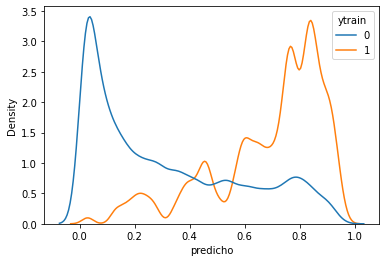

In [33]:
sns.kdeplot(data=df_trainLR, x='predicho', hue='ytrain', common_norm= False, bw=0.1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


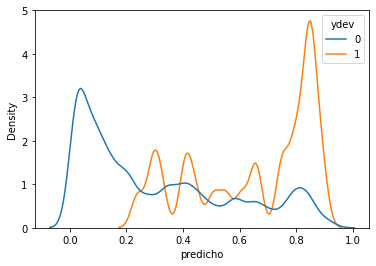

In [34]:
sns.kdeplot(data=df_DEvLR, x='predicho', hue='ydev', common_norm= False, bw=0.1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


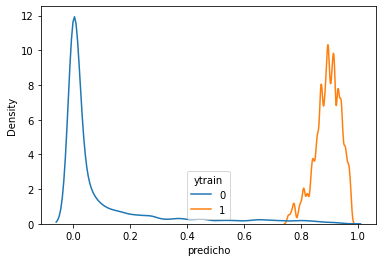

In [35]:
sns.kdeplot(data=df_trainLGB, x='predicho', hue='ytrain', common_norm= False, bw=0.1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


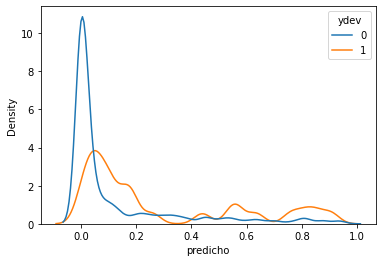

In [36]:
sns.kdeplot(data=df_devLGB, x='predicho', hue='ydev', common_norm= False, bw=0.1)

In [37]:
def dameProbaReal(predicho, real,scorePuntual, ventana):
  df= pd.DataFrame(
    {
      'predicho' : predicho,
     'real' : real
    }
  )
  df2 = df[df['predicho'] > scorePuntual - ventana ]
  df2 = df2[df2['predicho'] < scorePuntual + ventana ]
  return(np.mean(df2["real"]))

In [38]:
def dameColumnaReales(predicho, real, ventana):
  probas = np.zeros(len(predicho))
  for i in range(0, len(probas)):
    probas[i] = dameProbaReal(predicho, real, predicho[i], ventana)
  return probas

In [39]:
dameProbaReal(lgb.predict_proba(xdev)[:,1], ydev, 0.1, 0.1)

0.0399002493765586

In [40]:
probasReales = dameColumnaReales(lgb.predict_proba(xdev)[:,1], ydev, 0.1)

In [41]:
predlrtrain = lr1.predict_proba(xtrain)[:,1]
predlrdev = lr1.predict_proba(xdev)[:,1]
predlrtest = lr1.predict_proba(xtest)[:,1]

In [44]:
probasRealesTrainLr = dameColumnaReales(predlrtrain, ytrain, 0.1)
probasRealesDevLr = dameColumnaReales(predlrdev, ydev, 0.1)
probasRealesTestLr = dameColumnaReales(predlrtest, ytest, 0.1)


In [45]:
from sklearn.linear_model import LinearRegression, Ridge


In [46]:
xSuperModeloStacktrain = []
xSuperModeloStackdev = []
xSuperModeloStackTest = []
for i in range(0,len(predlrtrain)):
  xSuperModeloStacktrain.append([1,predlrtrain[i],predlrtrain[i]**2])
for i in range(0,len(predlrdev)):
  xSuperModeloStackdev.append([1,predlrdev[i],predlrdev[i]**2])
for i in range(0,len(predlrtest)):
  xSuperModeloStackTest.append([1,predlrtest[i],predlrtest[i]**2])

In [47]:
superModelo = Ridge().fit(xSuperModeloStackdev, ydev)

In [48]:
coef = superModelo.coef_

In [49]:
coef

array([0.        , 0.06976948, 0.16223088])

In [50]:
xsModelo = np.linspace(0,1,100)
ysModelo = list(map(lambda x: coef[0] + x*coef[1] + (x**2) *coef[2], xsModelo))

Text(0, 0.5, 'nueva score')

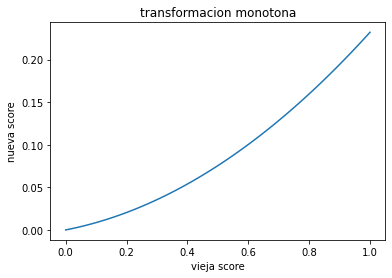

In [51]:
plt.plot(xsModelo, ysModelo)
plt.title("transformacion monotona")
plt.xlabel("vieja score")
plt.ylabel("nueva score")

In [52]:
predSupertrain = superModelo.predict(xSuperModeloStacktrain)
predSuperdev = superModelo.predict(xSuperModeloStackdev)
predSuperTest = superModelo.predict(xSuperModeloStackTest)

In [53]:
min(predSuperdev)

-0.0025916450597734085

In [54]:
probasRealesDeTransfTrain = dameColumnaReales(predSupertrain, ytrain, 0.1)


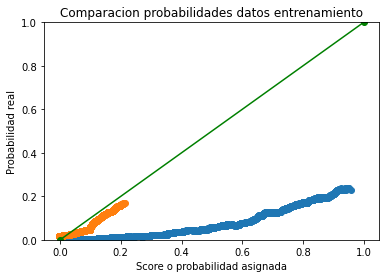

In [55]:

plt.plot([0,1],[0,1], 'go-')
plt.ylim([0,1])
plt.scatter(lr1.predict_proba(xtrain)[:,1], probasRealesTrainLr)
plt.scatter(predSupertrain, probasRealesDeTransfTrain)

#plt.xscale("log")
plt.ylabel("Probabilidad real")
plt.xlabel("Score o probabilidad asignada")
plt.title("Comparacion probabilidades datos entrenamiento")
plt.show()

In [56]:
probasRealesTrainLr = dameColumnaReales(predlrtrain, ytrain, 0.1)
probasRealesDevLr = dameColumnaReales(predlrdev, ydev, 0.1)
probasRealesDeTransfDev = dameColumnaReales(predSuperdev, ydev, 0.1)


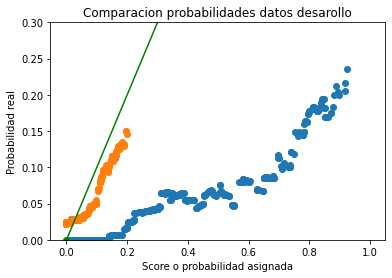

In [57]:

plt.plot([0,1],[0,1], 'go-')
plt.ylim([0,0.3])
plt.scatter(lr1.predict_proba(xdev)[:,1], probasRealesDevLr)
plt.scatter(predSuperdev, probasRealesDeTransfDev)
plt.title("Comparacion probabilidades datos desarollo")

plt.ylabel("Probabilidad real")
plt.xlabel("Score o probabilidad asignada")

plt.show()

In [58]:
probasRealesTestLr = dameColumnaReales(predlrtest, ytest, 0.1)
probasRealesTestLrTransformado = dameColumnaReales(predSuperTest, ytest, 0.1)

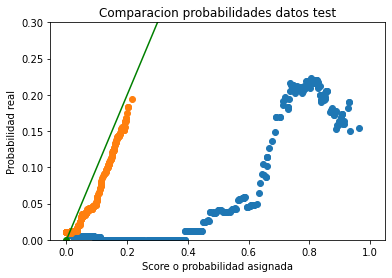

In [59]:

plt.plot([0,1],[0,1], 'go-')
plt.ylim([0,0.3])
plt.scatter(predlrtest, probasRealesTestLr)
plt.scatter(predSuperTest, probasRealesTestLrTransformado)
plt.title("Comparacion probabilidades datos test")

plt.ylabel("Probabilidad real")
plt.xlabel("Score o probabilidad asignada")

plt.show()

In [60]:
df_trainScoresTransformados= pd.DataFrame(
    {
      'predicho' : predSupertrain,
     'ytrain' : ytrain
    }
)

In [61]:
df_devScoresTransformados= pd.DataFrame(
    {
      'predicho' : predSuperdev,
     'ydev' : ydev
    }
)
df_testScoresTransformados= pd.DataFrame(
    {
      'predicho' : predSuperTest,
     'ytest' : ytest
    }
)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


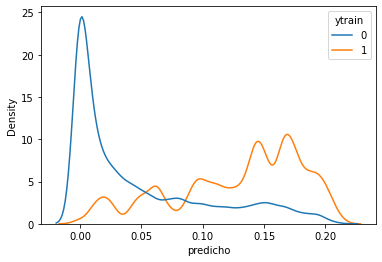

In [62]:
sns.kdeplot(data=df_trainScoresTransformados, x='predicho', hue='ytrain', common_norm= False, bw=0.1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


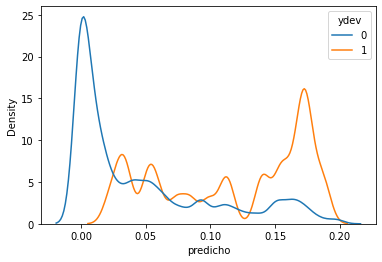

In [63]:
sns.kdeplot(data=df_devScoresTransformados, x='predicho', hue='ydev', common_norm= False, bw=0.1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


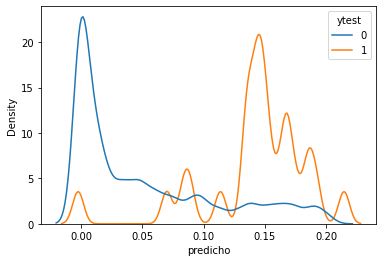

In [64]:
sns.kdeplot(data=df_testScoresTransformados, x='predicho', hue='ytest', common_norm= False, bw=0.1)

In [65]:
def cross_entropy(y,y_pre):
  loss=-np.sum(y*np.log(y_pre))
  return loss/float(y_pre.shape[0])

In [66]:
min(predSupertrain)

-0.0026543290478522287

In [67]:
errorTrainSinTransf  = log_loss(ytrain, lr1.predict_proba(xtrain)[:,1], )
errorTrainTransf  = log_loss(ytrain, predSupertrain +0.00, )

errorDevSinTransf  = log_loss(ydev, lr1.predict_proba(xdev)[:,1], )
errorDevTransf  = log_loss(ydev, predSuperdev+0.00, )

errorTestSinTransf  = log_loss(ytest, predlrtest, )
errorTestTransf  = log_loss(ytest, predSuperTest+0.00, )

In [68]:
cross_entropy(ydev, np.ones(len(ydev)), )


-0.0

In [69]:
errorDevSinTransf

0.4907004165527825

In [70]:
errorDevTransf

0.1594214498860367

In [71]:
errorTestSinTransf

0.5412803244841191

In [72]:
errorTestTransf

0.21002077736806504

In [73]:
df_trainScoresBaseline= pd.DataFrame(
    {
      'predicho' : ypredichoTrainBASELINE,
      'ytrain' : ytrain
    }
)
df_devScoresBaseline= pd.DataFrame(
    {
      'predicho' : ypredichodevBASELINE,
      'ydev' : ydev
    }
)

NameError: ignored

In [ ]:
sns.kdeplot(data=df_trainScoresBaseline, x='predicho', hue='ytrain', common_norm= False, bw=0.06)

In [ ]:
sns.kdeplot(data=df_devScoresBaseline, x='predicho', hue='ydev', common_norm= False, bw=0.08)

# Analisis de los sistemas y sus predicciones

In [ ]:
df_histLGB = (xdev.copy())
df_histLGB["yReal"] = ydev
df_histLGB["yPredicho"] = lgb.predict(xdev)

In [ ]:
min(lgb.predict(xdev))

In [ ]:
sns.kdeplot(data=df_histLGB, x='yPredicho', hue='yReal', common_norm= False, bw=0.1)

In [ ]:
df_histLR = (xdev.copy())
df_histLR["yReal"] = ydev
df_histLR["yPredicho"] = lr.predict(xdev)

In [ ]:
max(df_histLR["yPredicho"])

In [ ]:
sns.kdeplot(data=df_histLR, x='yPredicho', hue='yReal', common_norm= False, bw=0.1)

In [ ]:
df_baseline = (xdev.copy())
df_baseline["yReal"] = ydev
df_baseline["yPredicho"] = ypredichodev

In [ ]:
sns.kdeplot(data=df_baseline, x='yPredicho', hue='yReal', common_norm= False, bw=0.1)

# Axel

## Analisis de BMI para valores faltantes

In [ ]:
sns.kdeplot(data=df, x='bmi', hue='stroke', common_norm= False)

In [ ]:
df['bmi'].corr(df['avg_glucose_level'])

In [ ]:
df['bmi'].corr(df['age'])

In [ ]:
sum(df['bmi'].isna()) - len(df['bmi'].notna())

In [ ]:
def imputarDatasetPromedio(dataset, columna):
  imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
  imp_mean.fit(dataset[columna].array.reshape(-1, 1))
  valores = imp_mean.transform(dataset[columna].array.reshape(-1, 1))
  dfImpputado = dataset.copy()
  dfImpputado[columna] = valores
  return dfImpputado

In [ ]:
imputarDatasetPromedio(xdev, "bmi")

## Normalizar Columnas

In [ ]:
def normalizarDataset(dataset, columnas):
  dfImpputado = dataset.copy()
  stri = "normalizada"
  for columna in (columnas):
    scaler = StandardScaler()
    scaler.fit(dataset[columna].array.reshape(-1, 1))
    #imp_mean.fit(dataset[columna].array.reshape(-1, 1))
    valores = scaler.transform(dataset[columna].array.reshape(-1, 1))
    dfImpputado[columna+stri] = valores
  return dfImpputado

In [ ]:
normalizarDataset(xdev, ["avg_glucose_level", "bmi", "age"])

## Procesar cada uno de los 3 datasets y onehot encodear categoricas

In [ ]:
xtrain = imputarDatasetPromedio(xtrain, "bmi")
xdev = imputarDatasetPromedio(xdev, "bmi")
xtest = imputarDatasetPromedio(xtest, "bmi")
xtrain = normalizarDataset(xtrain, ["avg_glucose_level", "bmi", "age"])
xdev = normalizarDataset(xdev, ["avg_glucose_level", "bmi", "age"])
xtest = normalizarDataset(xtest, ["avg_glucose_level", "bmi", "age"])

categoricas = ["gender", "ever_married","smoking_status"]

xtrain = pd.get_dummies(xtrain, columns=categoricas, prefix=["gen","casad","smokstat"] )
xdev = pd.get_dummies(xdev, columns=categoricas, prefix=["gen","casad","smokstat"] )
xtest = pd.get_dummies(xtest, columns=categoricas, prefix=["gen","casad","smokstat"] )

In [ ]:
def baselineModeloEntrenar(datosXTrain, datosYTrain):
  datosXTrain = datosXTrain[["avg_glucose_levelnormalizada","bminormalizada", "agenormalizada", "hypertension", "heart_disease"]]
  aux = (datosXTrain.copy())
  aux["y"] = datosYTrain 
  acv = aux[aux.y == 1]
  noacv = aux[aux.y == 0]
  metricasAcv = acv.mean()
  metricasNoAcv = noacv.mean()
  return (metricasAcv, metricasNoAcv)


In [ ]:
def dist(x,y):
  return(abs(x-y))

In [ ]:
def baselineModeloPredecir(modeloBase, datosAPredecir):
  datosAPredecir = datosAPredecir[["avg_glucose_levelnormalizada","bminormalizada", "agenormalizada", "hypertension", "heart_disease"]]
  edad = list(datosAPredecir["agenormalizada"])
  glucosa = list(datosAPredecir["avg_glucose_levelnormalizada"])
  bmi = list(datosAPredecir["bminormalizada"])
  hyper = list(datosAPredecir["hypertension"])
  corazon = list(datosAPredecir["heart_disease"])
  edad2 = list(map(lambda x:x - min(edad),edad))
  res = []
  acv = modeloBase[0]
  noacv = modeloBase[1]
  for i in range(0, len(datosAPredecir)):
    suma = 0
    #if(dist(edad[i], acv["agenormalizada"])<dist(edad[i], noacv["agenormalizada"])):
    suma = suma + 0.1 * edad2[i]
    if(dist(glucosa[i], acv["avg_glucose_levelnormalizada"])<dist(glucosa[i], noacv["avg_glucose_levelnormalizada"])):
      suma = suma + 0.1*glucosa[i]
    if(dist(bmi[i], acv["bminormalizada"])<dist(bmi[i], noacv["bminormalizada"])):
      suma = suma +  0.1*bmi[i]
    if(dist(hyper[i], acv["hypertension"])<dist(hyper[i], noacv["hypertension"])):
      suma = suma + 0.2
    if(dist(corazon[i], acv["heart_disease"])<dist(corazon[i], noacv["heart_disease"])):
      suma = suma + 0.2
    res.append(suma)
  return res



In [ ]:
modeloBase = baselineModeloEntrenar(xtrain, ytrain)

In [ ]:
modeloBase

In [ ]:
ypredichodevBASELINE = baselineModeloPredecir(modeloBase,xdev)

In [ ]:
ypredichoTrainBASELINE = baselineModeloPredecir(modeloBase,xtrain)

In [ ]:
def evaluarSistema(predicciones, datosYreales):
  suma = 0
  datosYreales = list(datosYreales)
  for i in range(1, len(predicciones)):
    if(datosYreales[i]==1):
      suma = suma + 20*(dist(predicciones[i],datosYreales[i])**0.5)
    else:
      suma = suma + 1*(dist(predicciones[i],datosYreales[i])**0.5)
  return suma


In [ ]:
evaluarSistema(ypredichodev, ydev)

In [ ]:
todoZero = np.zeros(len(ydev))

In [ ]:
evaluarSistema(todoZero, ydev)

In [ ]:
medioTodo = np.ones(len(ydev))/2

In [ ]:
evaluarSistema(medioTodo, ydev)

In [ ]:
random01 = np.random.uniform(0,1,len(ydev))

In [ ]:
evaluarSistema(random01, ydev)

Graficos de Axel


In [ ]:
sns.barplot(x = "smoking_status", y = "stroke", data = df)
plt.show()
 
 
df["smoking_status"].value_counts()

In [ ]:

 
df.corr()


# Selección de hiperparámetros para LightGBM

In [ ]:
import lightgbm as lgb
from pprint import pprint
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from time import time


def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    print(params)
    pipe = make_pipeline(
        preprocessor,
        lgb.LGBMClassifier(random_state=42, 
                           objective='binary',
                           class_weight='balanced',
                           **params)
    )
    t0 = time()
    pipe.fit(xtrain, ytrain)
    train_time = time() - t0
    loss=1-mean_absolute_error(ydev, pipe.predict_proba(xdev)[:,1])
    print(f'loss {loss:.02f}')
    return dict(
        loss=loss,
        tr_loss=1-mean_absolute_error(ytrain, pipe.predict_proba(xtrain)[:,1]), 
        params=params,
        train_time=train_time,
        status=STATUS_OK
    )


In [ ]:
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 300, 10),
    'subsample': hp.quniform('subsample', 0.5, 1.0, 0.1),
    'learning_rate': hp.qloguniform('learning_rate', np.log(0.01), np.log(0.3), 0.01),
    'reg_alpha': hp.choice('ra', [0, hp.quniform('reg_alpha', 0.01, 0.1, 0.01)]),
}

trials = Trials()



In [ ]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=20, trials=trials)

In [ ]:
def flatten(doc, pref=''):
    res = {}
    for k, v in doc.items():
        k = f'{pref}.{k}' if pref else k
        if isinstance(v, dict):
            res.update(flatten(v, k))
        else:
            res[k] = v
    return res


df_res_hyperopt = pd.DataFrame(list(map(flatten, [e['result'] for e in trials.trials])))
df_res_hyperopt.sort_values('loss').head()




In [ ]:
df_res_hyperopt.loss.plot(style='-o', alpha=0.5)
plt.scatter([df_res_hyperopt.loss.argmin()], [df_res_hyperopt.loss.min()], c='r')
# df.tr_loss.plot()
plt.yscale('log')
plt.grid()



In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(df_res_hyperopt.tr_loss, df_res_hyperopt.loss, c=(df_res_hyperopt.loss-df_res_hyperopt.tr_loss)/df_res_hyperopt.loss*100)
plt.title('Comparison of training and dev losses.\n Color corresponds to overfitting percentage')
plt.colorbar()
m = min(df_res_hyperopt.tr_loss.min(), df_res_hyperopt.loss.min())
M = max(df_res_hyperopt.tr_loss.max(), df_res_hyperopt.loss.max())
plt.plot([m, M], [m, M], 'k--')
plt.xlabel('tr loss')
plt.ylabel('dev loss')
plt.grid()